# Import and Define the Control Problem

In [1]:
from collections import defaultdict
from typing import Optional

import numpy as np
import torch
import tqdm
from tensordict.nn import TensorDictModule
from tensordict.tensordict import TensorDict, TensorDictBase
from torch import nn

from torchrl.data import BoundedTensorSpec, CompositeSpec, UnboundedContinuousTensorSpec
from torchrl.envs import (
    CatTensors,
    EnvBase,
    Transform,
    TransformedEnv,
    UnsqueezeTransform,
)
from torchrl.envs.transforms.transforms import _apply_to_composite
from torchrl.envs.utils import check_env_specs, step_mdp

device = "cpu" if not torch.cuda.is_available() else "cuda:0"
print(device)

device = "cpu"

complex_type = torch.complex64
PSI_0 = np.array([1, 0]).reshape((2,1))
PSI_0_tensor = torch.tensor(PSI_0, dtype=complex_type).to(device)
PSI_F = np.array([0, 1]).reshape((2,1))
PSI_F_tensor = torch.tensor(PSI_F, dtype=complex_type).to(device)

H0 = np.array([[1,  0],
               [0, -1]])
H0_tensor = torch.tensor(H0, dtype=complex_type).to(device)
H1 = np.array([[0,  1],
               [1,  0]])
H1_tensor = torch.tensor(H1, dtype=complex_type).to(device)

cuda:0


# Define the Various Things We Need for TorchRL

## Step

In [2]:
# Step function advances along the environment
def _step(tensordict):

    # print("------------------")
    # print("in step")

    # Current quantum state and control value
    psi_real, psi_imag, control = tensordict["psi_real"], tensordict["psi_imag"], tensordict["action"].squeeze(-1)
    # print("psi_re", psi_real)
    # print("psi_im", psi_imag)
    # print("control", control)
    psi = psi_real + 1.0j*psi_imag

    # Timestep
    dt = tensordict["params", "dt"]

    # Cost Function -- Fidelity with Final State
    # print("psi", psi)
    # print("PSI_F_tensor", PSI_F_tensor)
    costs = 1 - torch.pow(torch.abs(torch.transpose(torch.conj_physical(PSI_F_tensor), 0, 1)@psi), 2)
    # Add penalty for large control
    max_val = 0.1
    multiplier = 1
    costs += multiplier*torch.clamp(torch.abs(control) - max_val, min=0).reshape(costs.shape)

    # Propagate along the state
    # print("H0", H0_tensor)
    # print("H1", H1_tensor)
    # print("control.shape", control.shape)
    # print("tensordict shape", tensordict.shape)
    if len(control.shape) > 0:
        H_dim = H1_tensor.size(dim=0)
        c_dim = control.size(dim=0)
        control_repeat = control.repeat(1,H_dim**2,1).T.reshape(c_dim, H_dim, H_dim)
        dt_repeat = dt.repeat(1,H_dim**2,1).T.reshape(c_dim, H_dim, H_dim)
        H0_repeat = H0_tensor.repeat(c_dim,1,1)
        H1_repeat = H1_tensor.repeat(c_dim,1,1)
        # print(control_repeat.shape, H0_repeat.shape, H1_repeat.shape, dt.shape)
        U = torch.linalg.matrix_exp(-1.0j*dt_repeat*(H0_repeat + control_repeat*H1_repeat))
    else:
        U = torch.linalg.matrix_exp(-1.0j*dt*(H0_tensor + control*H1_tensor))

    # print("U", U)
    new_psi = U@psi

    reward = -costs.view(*tensordict.shape, 1)
    done = torch.zeros_like(reward, dtype=torch.bool)
    out = TensorDict(
        {
            "psi_real": torch.real(new_psi),
            "psi_imag": torch.imag(new_psi),
            "params": tensordict["params"],
            "reward": reward,
            "done": done,
        },
        tensordict.shape,
    )
    return out

## Reset

In [3]:
# Reset function resets a run to the original starting state
def _reset(self, tensordict):

    # print("-----------------------")
    # print("in reset")

    psi_real = torch.real(PSI_0_tensor)
    psi_imag = torch.imag(PSI_0_tensor)

    if tensordict is None or tensordict.is_empty():
        # if no tensordict is passed, we generate a single set of hyperparameters
        # Otherwise, we assume that the input tensordict contains all the relevant
        # parameters to get started.
        tensordict = self.gen_params(batch_size=self.batch_size)
    else:
        psi_real = psi_real.repeat(tensordict.size(dim=0), 1, 1)
        psi_imag = psi_imag.repeat(tensordict.size(dim=0), 1, 1)


    # print("batch_dims", self.batch_dims)
        
    # print("psi_real - ", self.batch_dims, psi_real.shape)

    out = TensorDict(
        {
            "psi_real": psi_real,
            "psi_imag": psi_imag,
            "params": tensordict["params"],
        },
        batch_size=tensordict.shape,
    )

    # print("out psi_real", out["psi_real"])
    return out

## Make Spec

In [4]:
# Specifies the bounds of the environment
def _make_spec(self, td_params):

    # Under the hood, this will populate self.output_spec["observation"]
    self.observation_spec = CompositeSpec(
        psi_real=BoundedTensorSpec(
            low=-1,
            high=1,
            shape=PSI_0.shape,
            dtype=torch.float32)
        ,
        psi_imag=BoundedTensorSpec(
            low=-1,
            high=1,
            shape=PSI_0.shape,
            dtype=torch.float32)
        ,
        # we need to add the "params" to the observation specs, as we want
        # to pass it at each step during a rollout
        # params=make_composite_from_td(td_params["params"]),
        params=make_composite_from_td(td_params["params"]),
        shape=(),
    )
    
    # since the environment is stateless, we expect the previous output as input.
    # For this, EnvBase expects some state_spec to be available
    self.state_spec = self.observation_spec.clone()
    # action-spec will be automatically wrapped in input_spec when
    # `self.action_spec = spec` will be called supported
    self.action_spec = BoundedTensorSpec(
        low=-1,
        high=1,
        shape=(1,),
        dtype=torch.float32,
    )
    self.reward_spec = UnboundedContinuousTensorSpec(shape=(*td_params.shape, 1))


def make_composite_from_td(td):
    # custom funtion to convert a tensordict in a similar spec structure
    # of unbounded values.
    composite = CompositeSpec(
        {
            key: make_composite_from_td(tensor)
            if isinstance(tensor, TensorDictBase)
            else UnboundedContinuousTensorSpec(
                dtype=tensor.dtype, device=tensor.device, shape=tensor.shape
            )
            for key, tensor in td.items()
        },
        shape=td.shape,
    )
    return composite

## Set Seed

In [5]:
def _set_seed(self, seed: Optional[int]):
    rng = torch.manual_seed(seed)
    self.rng = rng

## Gen Params

In [6]:
def gen_params(dt=0.01, batch_size=None) -> TensorDictBase:
    """Returns a tensordict containing the physical parameters such as timestep and control stuff."""
    if batch_size is None:
        batch_size = []
    td = TensorDict(
        {
            "params": TensorDict(
                {
                    "dt": dt
                },
                [],
            )
        },
        [],
    )
    if batch_size:
        td = td.expand(batch_size).contiguous()
    return td

## Env

In [7]:
class QuantumEnv(EnvBase):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }
    batch_locked = False

    def __init__(self, td_params=None, seed=None, device="cpu"):
        if td_params is None:
            td_params = self.gen_params()

        super().__init__(device=device, batch_size=[])
        self._make_spec(td_params)
        if seed is None:
            seed = torch.empty((), dtype=torch.int64).random_().item()
        self.set_seed(seed)

    # Helpers: _make_step and gen_params
    gen_params = staticmethod(gen_params)
    _make_spec = _make_spec

    # Mandatory methods: _step, _reset and _set_seed
    _reset = _reset
    _step = staticmethod(_step)
    _set_seed = _set_seed

In [8]:
env = QuantumEnv()
check_env_specs(env)

check_env_specs succeeded!


In [9]:
print("observation_spec:", env.observation_spec)
print("state_spec:", env.state_spec)
print("reward_spec:", env.reward_spec)

observation_spec: CompositeSpec(
    psi_real: BoundedTensorSpec(
        shape=torch.Size([2, 1]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.float32, contiguous=True)),
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    psi_imag: BoundedTensorSpec(
        shape=torch.Size([2, 1]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.float32, contiguous=True)),
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    params: CompositeSpec(
        dt: UnboundedContinuousTensorSpec(
            shape=torch.Size([]),
            space=None,
            device=cpu,
            dtype=torch.float32,
            domain=continuous), 

In [10]:
td = env.reset()
print("reset tensordict", td)

reset tensordict TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        params: TensorDict(
            fields={
                dt: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([]),
            device=None,
            is_shared=False),
        psi_imag: Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        psi_real: Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)


In [11]:
td = env.rand_step(td)
print("random step tensordict", td)

random step tensordict TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
                params: TensorDict(
                    fields={
                        dt: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False)},
                    batch_size=torch.Size([]),
                    device=None,
                    is_shared=False),
                psi_imag: Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                psi_real: Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),

## Maybe do a Transformation?

# Test the Rollout

In [12]:
def simple_rollout(steps=100):
    # preallocate:
    data = TensorDict({}, [steps])
    # reset
    _data = env.reset()
    for i in range(steps):
        _data["action"] = env.action_spec.rand()
        _data = env.step(_data)
        data[i] = _data
        _data = step_mdp(_data, keep_other=True)
    return data


print("data from rollout:", simple_rollout(3))

data from rollout: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                params: TensorDict(
                    fields={
                        dt: Tensor(shape=torch.Size([3]), device=cpu, dtype=torch.float32, is_shared=False)},
                    batch_size=torch.Size([3]),
                    device=None,
                    is_shared=False),
                psi_imag: Tensor(shape=torch.Size([3, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                psi_real: Tensor(shape=torch.Size([3, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.float32, i

## Batch

In [13]:
batch_size = 10  # number of environments to be executed in batch
td = env.reset(env.gen_params(batch_size=[batch_size]))
print("reset (batch size of 10)", td)
td = env.rand_step(td)
print("rand step (batch size of 10)", td)

reset (batch size of 10) TensorDict(
    fields={
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        params: TensorDict(
            fields={
                dt: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([10]),
            device=None,
            is_shared=False),
        psi_imag: Tensor(shape=torch.Size([10, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        psi_real: Tensor(shape=torch.Size([10, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        terminated: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([10]),
    device=None,
    is_shared=False)
rand step (batch size of 10) TensorDict(
    fields={
        action: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype

/tmp/ipykernel_32507/3886983110.py:34: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181081/work/aten/src/ATen/native/TensorShape.cpp:3614.)
  control_repeat = control.repeat(1,H_dim**2,1).T.reshape(c_dim, H_dim, H_dim)


In [14]:
rollout = env.rollout(
    3,
    auto_reset=False,  # we're executing the reset out of the ``rollout`` call
    tensordict=env.reset(env.gen_params(batch_size=[batch_size])),
)
print("rollout of len 3 (batch size of 10):", rollout)

rollout of len 3 (batch size of 10): TensorDict(
    fields={
        action: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                params: TensorDict(
                    fields={
                        dt: Tensor(shape=torch.Size([10, 3]), device=cpu, dtype=torch.float32, is_shared=False)},
                    batch_size=torch.Size([10, 3]),
                    device=None,
                    is_shared=False),
                psi_imag: Tensor(shape=torch.Size([10, 3, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                psi_real: Tensor(shape=torch.Size([10, 3, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Si

In [15]:
env.reset()

TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        params: TensorDict(
            fields={
                dt: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([]),
            device=None,
            is_shared=False),
        psi_imag: Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        psi_real: Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)

In [16]:
# env = TransformedEnv(
#     env,
#     CatTensors(
#     in_keys=["psi_real", "psi_imag"], dim=0, out_key="observation", del_keys=False
# ),
# )
# check_env_specs(env)

In [17]:
env

QuantumEnv()

In [18]:

torch.manual_seed(0)
env.set_seed(0)

class myNet(nn.Module):

    def __init__(self):
        super(myNet, self).__init__()
        self.net = nn.Sequential(
                    nn.Linear(4, 64),
                    nn.Tanh(),
                    nn.Linear(64, 64),
                    nn.Tanh(),
                    nn.Linear(64, 64),
                    nn.Tanh(),
                    nn.Linear(64, 1),
                    nn.Tanh()
                    )

    def forward(self, x1, x2):
        # print(x1.shape, x2.shape)
        flattened = torch.squeeze(torch.hstack((x1, x2)))
        # print(flattened.shape)
        return self.net(flattened)

net = myNet()
policy = TensorDictModule(
    net,
    in_keys=["psi_real", "psi_imag"],
    out_keys=["action"],
)

In [19]:
policy

TensorDictModule(
    module=myNet(
      (net): Sequential(
        (0): Linear(in_features=4, out_features=64, bias=True)
        (1): Tanh()
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): Tanh()
        (4): Linear(in_features=64, out_features=64, bias=True)
        (5): Tanh()
        (6): Linear(in_features=64, out_features=1, bias=True)
        (7): Tanh()
      )
    ),
    device=cpu,
    in_keys=['psi_real', 'psi_imag'],
    out_keys=['action'])

In [20]:
optim = torch.optim.Adam(policy.parameters(), lr=1e-3)

In [21]:
env.reset(env.gen_params(batch_size=[10]))

TensorDict(
    fields={
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        params: TensorDict(
            fields={
                dt: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([10]),
            device=None,
            is_shared=False),
        psi_imag: Tensor(shape=torch.Size([10, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        psi_real: Tensor(shape=torch.Size([10, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        terminated: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([10]),
    device=None,
    is_shared=False)

# Train Network

In [22]:
batch_size = 100
rollout_len = 1000
pbar = tqdm.tqdm(range(20_000 // batch_size))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, 20_000)
logs = defaultdict(list)

for _ in pbar:
    init_td = env.reset(env.gen_params(batch_size=[batch_size]))
    rollout = env.rollout(rollout_len, policy, tensordict=init_td, auto_reset=False)
    traj_return = rollout["next", "reward"].mean()
    (-traj_return).backward()
    gn = torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
    optim.step()
    optim.zero_grad()
    pbar.set_description(
        f"reward: {traj_return: 4.4f}, "
        f"last reward: {rollout[..., -1]['next', 'reward'].mean(): 4.4f}, gradient norm: {gn: 4.4}"
    )
    logs["return"].append(traj_return.item())
    logs["last_reward"].append(rollout[..., -1]["next", "reward"].mean().item())
    scheduler.step()


def plot():
    import matplotlib
    from matplotlib import pyplot as plt

    is_ipython = "inline" in matplotlib.get_backend()
    if is_ipython:
        from IPython import display

    with plt.ion():
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(logs["return"])
        plt.title("returns")
        plt.xlabel("iteration")
        plt.subplot(1, 2, 2)
        plt.plot(logs["last_reward"])
        plt.title("last reward")
        plt.xlabel("iteration")
        if is_ipython:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        plt.show()


plot()

  0%|          | 0/200 [00:00<?, ?it/s]

reward: -0.9947, last reward: -0.9935, gradient norm:  0.05616:   4%|▍         | 8/200 [00:13<05:24,  1.69s/it]


KeyboardInterrupt: 

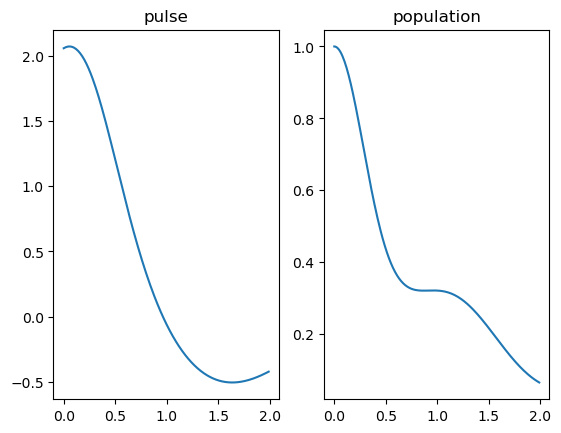

In [ ]:
import matplotlib.pyplot as plt
import qutip as qt

dt = 0.01
timesteps = 200
tlist = np.arange(timesteps)*dt
def get_control_pulse(net, timesteps=timesteps, dt=dt):
    psi = PSI_0_tensor
    cntrl_seq = torch.zeros(timesteps)
    for i in range(timesteps):
        cntrl = net(torch.real(psi).reshape((1,2,1)), torch.imag(psi).reshape((1,2,1)))
        cntrl_seq[i] = cntrl
        U = torch.linalg.matrix_exp(-1.0j*dt*(H0_tensor + cntrl*H1_tensor))
        psi = U@psi

    return cntrl_seq.detach().numpy()

pulse = get_control_pulse(net)
def Ham(t, tlist):
    tdiff = np.abs(tlist - t)
    return qt.Qobj(H0 + pulse[np.argmin(tdiff)]*H1)

states_qt = qt.sesolve(lambda t, args: Ham(t, tlist), qt.Qobj(PSI_0), tlist=tlist)
prob0_qt = [np.abs(s[0][0][0])**2 for s in states_qt.states]

f, ax = plt.subplots(ncols=2)
ax[0].set_title("pulse")
ax[1].set_title("population")
ax[0].plot(tlist, pulse)
ax[1].plot(tlist, prob0_qt)
plt.show()
